In [50]:
n1=400

# exponentially decaying sinusiods with different frequencies
inp = zeros(Float32,n1)
for j in n1÷15:n1÷5:n1
    wave = zeros(Float32,n1)
    for x in j:399
        y = (x-j)/400
        wave[x] = exp(-y*15)*sin(y*0.95*j)
    end
    inp += wave
end

res = similar(inp);
bak = similar(inp);

In [51]:
# import Pkg; Pkg.add("Plots")

In [52]:
using Pkg
# Pkg.add("NPZ")
using NPZ

In [53]:
using Plots

function stems(data, label, color) 
    "plot data using stems"
    plt=plot(zeros(Float32, n1), label=:none, color=:black)
    plot!(plt, data, line=:stem,
          label=label, color=color, legend=:outerleft, 
          xlim=[0.5, n1+0.5], border=:none)   
    return plt
end

stems (generic function with 1 method)

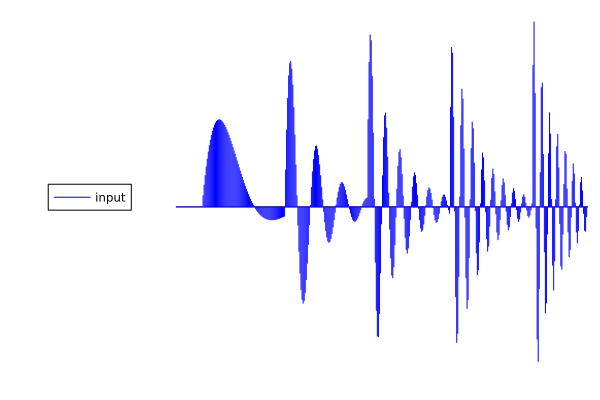

In [54]:
plot_input = stems(inp,"input",:blue)

In [55]:
function stream!(inv::Bool, d::Vector{T}, r::Vector{T}, na::Int, λ::Real) where T <: Real
    a = zeros(T, na) # streaming PEF
    dd = da = zero(T) # d (dot) d, d (dot) a
    for ia in 1:na
        if (inv) 
            d[ia] = r[ia]
        else 
            r[ia] = d[ia]
        end
        dd += d[ia]*d[ia]
    end
    for i1 in na+1:n1
        if (inv) # from r to d
            rn = r[i1] / λ 
            dn = rn * (λ + dd) - da
            d[i1] = dn
        else     # from d to r
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            r[i1] = λ * rn
        end
        # update PEF
        for ia in 1:na; a[ia] -= rn * d[i1-ia]; end
        # update dd and da
        dd += dn*dn - d[i1-na] * d[i1-na]   
        da = dn * a[1]
        for ia in 2:na; da += a[ia] * d[i1-ia+1]; end
    end
end

stream! (generic function with 1 method)

In [56]:
stream!(false, inp, res, 2, 0.1)
plot_decon = stems(res, "decon", :green);

In [57]:
stream!(true, bak, res, 2, 0.1)
plot_inverse = stems(bak,"inverse",:purple);

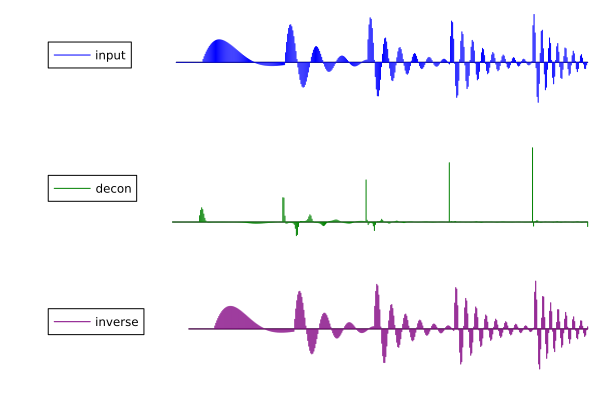

In [58]:
plot(plot_input, plot_decon, plot_inverse, layout=(3, 1))

In [59]:
# savefig("stream.pdf")

### Multiple dimensions

In [60]:
inp2 = deepcopy(inp)
known = ones(Bool,n1)

# Cut holes in the data and create a mask
for hole in (55, 153, 246, 301, 376)
    inp2[hole:hole+20] .= 0
    known[hole:hole+20] .= false
end

In [61]:
function stream_missing!(d::Vector{T}, k::Vector{Bool}, na::Int, λ::Real) where T <: Real
    a = zeros(T, na) # streaming PEF
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na
        dd += d[ia]*d[ia]
    end
    for i1 in na+1:n1
        if (k[i1]) # from d to r
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
        else       # assume r=0
            dn = - da
            rn = zero(T)
            d[i1] = dn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-ia]
        end
        # update dd and da
        dd += dn*dn - d[i1-na] * d[i1-na]   
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1-ia+1]
        end
    end
end

stream_missing! (generic function with 1 method)

In [62]:
plot_ideal = stems(inp,"ideal ",:blue);
plot_hole = stems(inp2,"input ",:green);

In [63]:
miss = deepcopy(inp2)
stream_missing!(miss,known,2,0.05)

In [64]:
plot_interp = stems(miss,"filled",:purple);

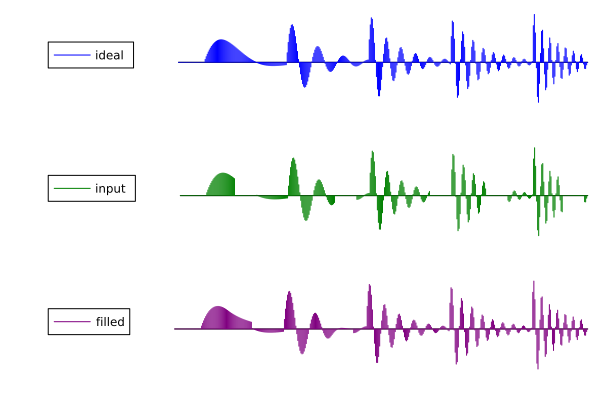

In [65]:
plot(plot_ideal, plot_hole, plot_interp, layout=(3, 1))

In [66]:
# savefig("mstream.pdf")

In [67]:
# import Pkg; Pkg.add("ZipFile")

In [68]:
using ZipFile

# download data from a public server
download("https://zenodo.org/api/records/11099632/files-archive", "files.zip")
# unzip the archive file
r = ZipFile.Reader("files.zip")

ZipFile.Reader for IOStream(<file files.zip>) containing 3 files:

uncompressedsize method  mtime            name
----------------------------------------------
          125000 Store   2024-09-25 22-12 seis.rsf@
           65536 Store   2024-09-25 22-12 wood.rsf@
           65536 Store   2024-09-25 22-12 herr.rsf@


In [69]:
# make a dictionary of files for easy access
patterns = Dict{String, IO}()
for file in r.files
    name = splitext(file.name)[1]
    patterns[name] = file
end

In [70]:
# download "wood" pattern
wood = Array{Float32}(undef, 128, 128) # single-precision array
read!(patterns["wood"], wood)

128×128 Matrix{Float32}:
 -122.865   -133.865     -116.865   …   -69.8653    -8.8653    49.1347
   32.1347   -97.8653    -123.865        34.1347    14.1347     0.134705
    6.1347    52.1347     -62.8653      -63.8653    64.1347    28.1347
  -18.8653    -5.8653      63.1347     -117.865    -94.8653    -0.865295
    2.1347   -20.8653     -10.8653     -127.865   -109.865   -107.865
   69.1347    -0.865295   -38.8653  …  -140.865   -122.865   -113.865
  100.135     63.1347      48.1347     -145.865   -139.865   -137.865
   85.1347    99.1347      89.1347     -145.865   -146.865   -145.865
   82.1347    69.1347      84.1347     -113.865   -143.865   -145.865
   75.1347    69.1347      76.1347      -72.8653   -95.8653  -134.865
    ⋮                               ⋱     ⋮                  
  -25.8653   -40.8653       6.1347      -54.8653   -72.8653   -45.8653
  -24.8653    -6.8653     -44.8653  …   -45.8653   -63.8653   -70.8653
   39.1347    34.1347     -32.8653        4.1347   -31.8653   -

In [71]:
npzwrite("npy/j_wood.npy",wood)

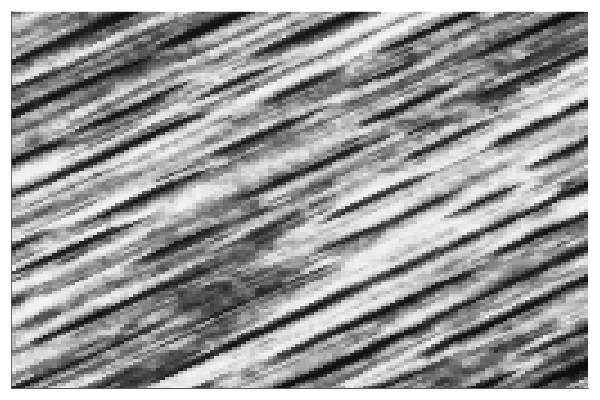

In [72]:
heatmap(wood,axis=nothing,legend=:none,color=:grays)

In [73]:
function punch_hole(data::Matrix{T}) where T <: Real
    # make an elliptical hole
    n1, n2 = size(data)
    hole = similar(data)
    mask = zeros(Bool, n1, n2)
    for i2 in 1:n2, i1 in 1:n1
        x = (i1-1)/n1 - 0.5
        y = (i2-1)/n2 - 0.3
        u =  x + y
        v = (x - y)/2
        if (u*u + v*v < 0.15)
            hole[i1,i2] = zero(T)
        else
            hole[i1,i2] = data[i1,i2]
            mask[i1,i2] = true
        end
    end
    return hole, mask
end

whole, wmask = punch_hole(wood);

In [74]:
npzwrite("npy/julia_whole.npy",whole)
npzwrite("npy/julia_wmask.npy",wmask)

In [75]:
function helix(lag::Vector{Tuple{T, T}}, ci::CartesianIndices) where T <: Integer
    "convert filter lags to helix lags for a given grid"
    # middle of the grid
    mid = CartesianIndex(Tuple(last(ci)) .÷ 2)
    # helix index of middle
    hmid = LinearIndices(ci)[mid]
    # from Cartesian shift to helix shift
    return LinearIndices(ci)[map(x -> CartesianIndex(x) + mid, lag)] .- hmid
end

helix (generic function with 1 method)

In [76]:
import Random

function stream_missing_helix!(d, k, 
                               lag::Vector{Tuple{I, I}},
                               λ::Real, std=0, seed=1) where I <: Integer
    "Fill missing data in multiple dimensions using streaming PEF on a helix"
    n1, na = length(d), length(lag)
    hlag = helix(lag, CartesianIndices(d))
    maxlag = maximum(hlag)
    T = eltype(d)
    a = zeros(T, na) # streaming PEF
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na
        dd += d[maxlag+1-hlag[ia]]^2
    end
    # println("dd : $dd")
    npzwrite("npy/julia_dd.npy", dd)
    Random.seed!(seed)
    for i1 in maxlag+1:n1
        if (k[i1])
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
        else # assume r_n is random
            rn = std * randn() / λ
            dn = rn * (λ + dd) - da
            d[i1] = dn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-hlag[ia]]
        end
        # update dd and da
        dd += dn * dn - d[i1-maxlag] * d[i1-maxlag]   
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1+1-hlag[ia]]
        end
    end
    println("sum d : ",sum(d))
end

stream_missing_helix! (generic function with 3 methods)

In [77]:
# 11 x 11 PEF
lag=[(x,0) for x in 1:5]
for k in 1:10
    lag = vcat(lag,[(x,k) for x in -5:5])
end
print(lag)

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (-5, 1), (-4, 1), (-3, 1), (-2, 1), (-1, 1), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (-5, 2), (-4, 2), (-3, 2), (-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (-5, 3), (-4, 3), (-3, 3), (-2, 3), (-1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (-5, 4), (-4, 4), (-3, 4), (-2, 4), (-1, 4), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (-5, 5), (-4, 5), (-3, 5), (-2, 5), (-1, 5), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (-5, 6), (-4, 6), (-3, 6), (-2, 6), (-1, 6), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (-5, 7), (-4, 7), (-3, 7), (-2, 7), (-1, 7), (0, 7), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (-5, 8), (-4, 8), (-3, 8), (-2, 8), (-1, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (-5, 9), (-4, 9), (-3, 9), (-2, 9), (-1, 9), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (-5, 10), (-4, 10), (-3, 10), (-2, 10), (-1, 10), (0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10)]

In [78]:
function fill_hole(forward::Bool, hole, mask, pad::Integer, noise=0, seed=1)
    if forward
        println("ok")
        holepad = hcat(zeros(Float32, size(hole, 1), pad), hole)
        maskpad = hcat(zeros(Bool, size(hole, 1), pad), mask)
        stream_missing_helix!(holepad, maskpad, lag, 1e6, noise, seed)
        return holepad[:,pad+1:end]
    else
        rhole = reverse(hole)
        rmask = reverse(mask)
        println(sum(hole))
        println(sum(mask))
        println(mask)
        holepad = hcat(zeros(Float32, size(rhole, 1), pad), rhole)
        maskpad = hcat(zeros(Bool, size(rhole, 1), pad), rmask)
        stream_missing_helix!(holepad, maskpad, lag, 1e6, noise, seed+1)
        return reverse(holepad[:,pad+1:end])
    end
end

fill_hole (generic function with 3 methods)

In [79]:
filled1 = fill_hole(true, whole, wmask, 20);
filled2 = fill_hole(false, whole, wmask, 20);

ok
sum d : -14005.476
-12380.774
9385
Bool[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [80]:
plot2(data, title) = heatmap(data, axis=nothing, yflip=:true, clim=(-137, 137),
                             legend=:none, color=:grays, title=title)

plot2 (generic function with 1 method)

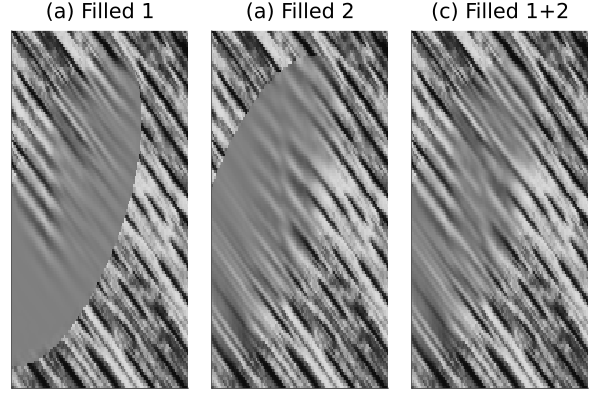

In [81]:
p1 = plot2(filled1, "(a) Filled 1")
p2 = plot2(filled2, "(a) Filled 2")
p3 = plot2(filled1 + filled2 - whole, "(c) Filled 1+2")
plot(p1, p2, p3, layout=(1, 3))

In [82]:
using NPZ
npzwrite("npy/julia_filled1.npy", filled1)
npzwrite("npy/julia_filled2.npy", filled2)
npzwrite("npy/julia_both_filled.npy", filled1 + filled2 - whole)

In [83]:
# savefig("interp.pdf")

ok
sum d : -17341.59
-12380.774
9385
Bool[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

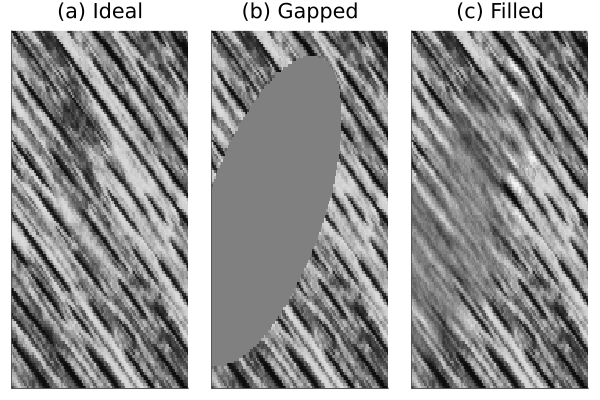

In [84]:
filled = fill_hole(true,  whole, wmask, 20, 2) + 
         fill_hole(false, whole, wmask, 20, 2) - whole

p1 = plot2(wood, "(a) Ideal") 
p2 = plot2(whole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [85]:
# savefig("wood-hole.pdf")

ok
sum d : -17341.59
-12380.774
9385
Bool[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

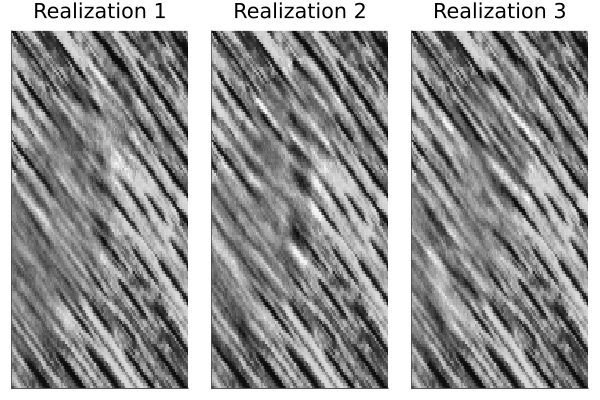

In [86]:
p = Array{Plots.Plot}(undef,3)
for k in 1:3
    filled = fill_hole(true,  whole, wmask, 20, 2, k) + 
             fill_hole(false, whole, wmask, 20, 2, k+3) - whole
    p[k] = plot2(filled, "Realization $k") 
end
plot(p[1], p[2], p[3], layout=(1, 3))

In [87]:
# savefig("realiz.pdf")

In [88]:
# "herring" pattern
herr = Array{Float32}(undef, 128, 128) # single-precision array
# read data
read!(patterns["herr"], herr)
# make a hole
hhole, hmask = punch_hole(herr);

ok
sum d : -13115.0
-13283.529
9385
Bool[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

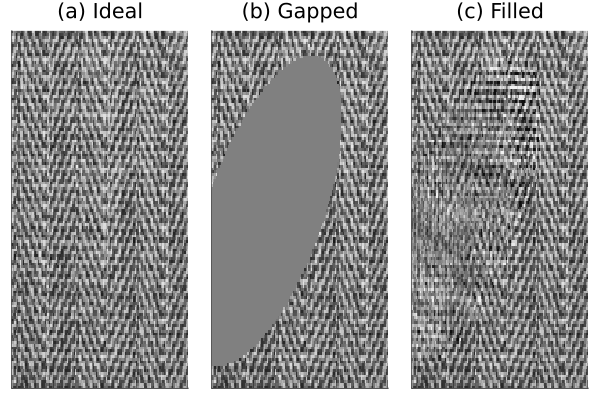

In [89]:
filled = fill_hole(true,  hhole, hmask, 20, 6) + 
         fill_hole(false, hhole, hmask, 20, 6) - hhole

p1 = plot2(herr, "(a) Ideal") 
p2 = plot2(hhole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [90]:
savefig("herr-hole.pdf")

"c:\\Users\\JON\\Desktop\\pef_stanford\\herr-hole.pdf"

In [91]:
# "seismic" pattern
seis = Array{Float32}(undef, 250, 125) # single-precision array
# read data
read!(patterns["seis"], seis)

250×125 Matrix{Float32}:
      0.0      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0  …      0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
      ⋮                               ⋱                             
  -5576.0  -4176.0  -4244.0  -5524.0       204.0  -1292.0     64.0    -28.0
    996.0  -1392.0  -2100.0  -5584.0      4100.0   1920.0   1908.0  -1

In [92]:
using Statistics

# normalize
m = mean(seis)
seis .-= m
scale = std(wood)/std(seis)
seis *= scale

# make a hole
shole, smask = punch_hole(seis);

ok
sum d : -1056.0542
-2336.013
17901
Bool[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

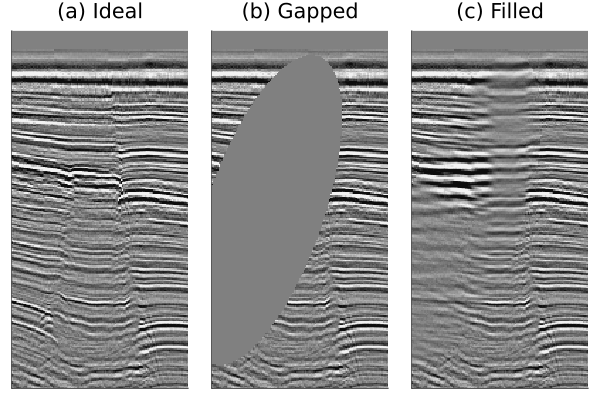

In [93]:
filled = fill_hole(true,  shole, smask, 20, 0.7) + 
         fill_hole(false, shole, smask, 20, 0.7) - shole

p1 = plot2(seis, "(a) Ideal") 
p2 = plot2(shole, "(b) Gapped")
p3 = plot2(filled, "(c) Filled")
plot(p1, p2, p3, layout=(1, 3))

In [94]:
# savefig("WGstack-hole.pdf")

In [95]:
function stream_helix!(inv::Bool, d, r, lag::Vector{Tuple{I, I}}, λ::Real) where I <: Integer
    n1, na = length(d), length(lag)
    hlag = helix(lag, CartesianIndices(d))
    maxlag = maximum(hlag)
    T = eltype(d)
    a = zeros(T, na) # streaming PEF
    for i1 in 1:maxlag
        if (inv) 
            d[i1] = r[i1]
        else 
            r[i1] = d[i1]
        end
    end
    da = zero(T) # d (dot) a
    dd = zero(T) # d (dot) d
    for ia in 1:na      
        dd += d[maxlag+1-hlag[ia]]^2
    end
    for i1 in maxlag+1:n1
        if (inv) 
            rn = r[i1] / λ 
            dn = rn * (λ + dd) - da
            d[i1] = dn
        else 
            dn = d[i1]
            rn = (dn + da) / (λ + dd)
            r[i1] = λ * rn
        end
        # update PEF
        for ia in 1:na
            a[ia] -= rn * d[i1-hlag[ia]]
        end
        # update dd and da
        dd += dn * dn - d[i1-maxlag] * d[i1-maxlag]    
        da = dn * a[1]
        for ia in 2:na
            da += a[ia] * d[i1+1-hlag[ia]]
        end
    end
end

stream_helix! (generic function with 1 method)

In [96]:
# apply helix filter
pad = hcat(zeros(Float32, size(seis, 1), 20), seis)
res= similar(pad)
stream_helix!(false, pad, res, lag, 1e6) # pad -> res
stream_helix!(true,  pad, res, lag, 1e6) # pad <- res

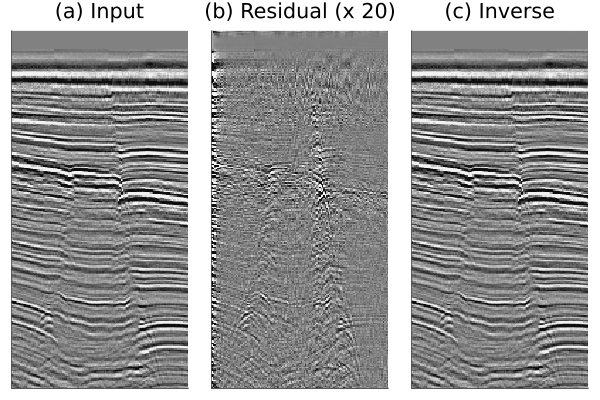

In [97]:
p1 = plot2(seis, "(a) Input") 
p2 = plot2(20*res[:,21:end], "(b) Residual (x 20)")
p3 = plot2(pad[:,21:end], "(c) Inverse")
plot(p1, p2, p3, layout=(1, 3))